In [6]:
pwd

'/sdf/home/c/carsmith/flash_reconstruction/flash_detection/notebooks'

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
from data_utils import *
from waveforms.make_waveform import BatchedLightSimulation

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using CUDA

In [3]:
# Loading in data
load_wfs = np.load('/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delta_t_stratsamples.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.1
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times, photon_bins, photon_list = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0) # [B, L]

    # Normalizing waveforms
    waveforms = (waveforms - waveforms.mean(dim=1, keepdim=True)) / (waveforms.std(dim=1, keepdim=True) + 1e-8)
    waveforms = waveforms.unsqueeze(1)  # add channel dimension [B,1,L]

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension
    photon_bins = torch.stack(photon_bins, dim=0)
    photon_bins = photon_bins.unsqueeze(1)

    # Normalize entire tensor
    # max_count = photon_bins.max().item() if photon_bins.numel() > 0 else 1
    # photon_bins = photon_bins / max_count

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    photon_list = [item[4] for item in batch]
    photon_list = torch.tensor(photon_list)
    # max_photons = photon_list.max().item() if photon_list.numel() > 0 else 1
    # photon_list_norm = photon_list / max_photons
    
    return waveforms, arrival_times, hit_times, photon_bins, photon_list
    

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (63000, 7000, 0)


In [4]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(hit_times[3].shape)

torch.Size([2])


/lscratch/carsmith/tmp/ipykernel_980081/236944743.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


### Inspecting Data

hit_times: torch.Size([25, 2])
torch.Size([25, 1, 8000])
torch.Size([25, 1, 8000])
torch.Size([25, 1, 8000])
41


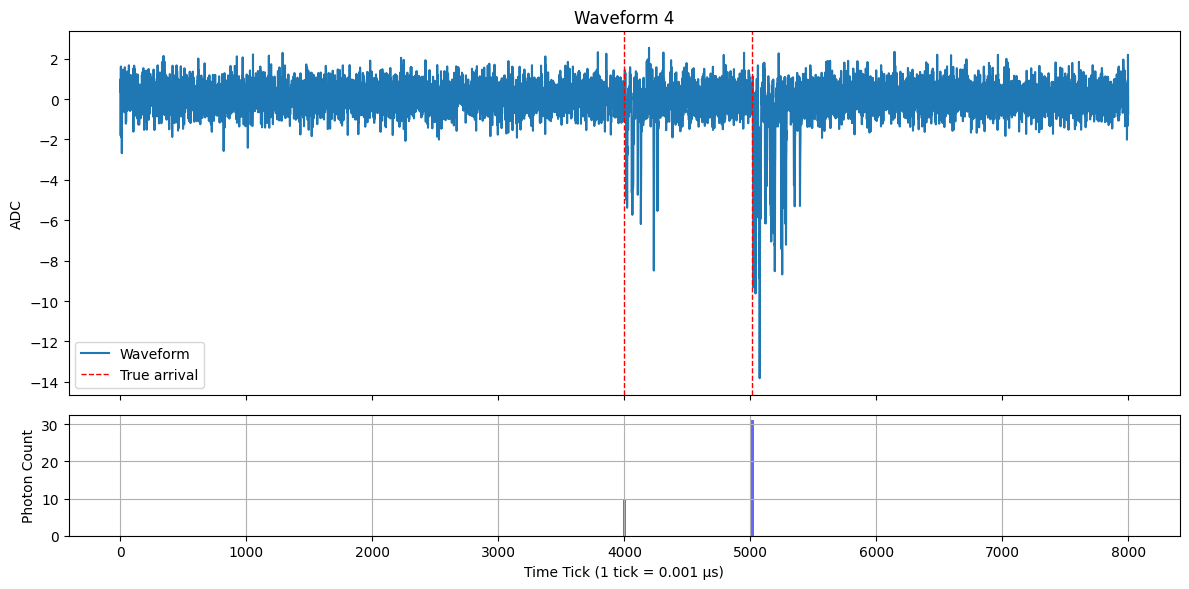

In [6]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
print(photon_bins.shape)

waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print(photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=20.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Doing the training yuhh
from model import *
from utils import *
import torch.optim as optim
import wandb

epochs = 50
device = 'cuda'

# try tracking with wandb
logger = wandb.init(
    project="unet_training_grid",
    name="new_200k_lambda_001_poiss_log",
    config={
        "epochs": epochs,
        "batch_size": batch_size,
        "lr": 1e-4,
    }
)

model = UNet1D()
model.to(device)
wandb.watch(model, log="all", log_freq=100)

criterion = torch.nn.BCEWithLogitsLoss() # combines sigmoid + loss
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

mode = 'mined_bce'
results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_28_50epochs.pth")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carsmith (carsmith-stanford-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50:   4%|█▎                            | 314/7200 [01:15<21:25,  5.36it/s, train_loss=0.344, train_acc=0.973, train_pure=0.0363]

In [ ]:
device = 'cuda'
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, hit_times, photon_target = data.to(device), target.to(device), hit_times.to(device), photon_target.to(device) # model output is [25, 992] but target is [25, 1000] due to mismatch in downsampling/upsampling shapes
    class_output, reg_output = model(data)
    print(class_output.shape)
    break
    
rmse = regression_rmse(hit_times, photon_target, reg_output, class_output, device)
print(rmse)

In [ ]:
# plot results['train_pure'] and results['train_acc'] on subfigures next to each other
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot train_pure
ax1.plot(results['train_pure'], linewidth=2)
ax1.set_title("Training Purity")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Purity")
ax1.legend()
ax1.grid(True)

# Plot train_acc
ax2.plot(results['train_acc'], color="orange", linewidth=2)
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
val_epochs = np.arange(len(results['eval_loss'])) * 5 + 5
plt.figure(figsize=(8, 5))
plt.plot(results['train_loss'], linewidth=2, marker='o', label='Train Loss')
plt.plot(val_epochs, results['eval_loss'], linewidth=2, marker='o', label='Eval Loss')
plt.xlabel("Epochs")
plt.ylabel("Poisson NLL Loss on Log(Counts)")
plt.title(r"Log Regression: UNet Train & Val Loss, 10k, $\lambda=0.001$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Instantiating from a Checkpoint
# checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_2_2_10epochs.pth", weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# start_epoch = epochs + 1

# more_epochs = 20
# more_results = train_model_2(model, train_loader, val_loader, scheduler, optimizer, device, more_epochs, mode, logger)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}, f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_2_2_10epochs.pth")

In [ ]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'scheduler_state_dict': scheduler.state_dict(),
# }, f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/class_reg_ckpts/norm_overtrain_unet.pth")

### Inspecting Classification Loss Calculation

In [ ]:
# Load from a checkpoint
# from model import *
# from utils import *
# model = UNet1D()
# checkpoint = torch.load("class+reg_100.pth", weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])
# model = model.to('cuda')  # move model to GPU if needed
# model.eval()

In [ ]:
model.eval()
device = 'cuda'
train_progress = tqdm(val_loader, leave=False, position=0)
for i, (data, target, hit_times, photon_target, photon_list) in enumerate(train_progress):
    data, target, hit_times, photon_target = data.to(device), target.to(device), hit_times.to(device), photon_target.to(device) # model output is [25, 992] but target is [25, 1000] due to mismatch in downsampling/upsampling shapes
    class_output, reg_output = model(data)
    print(class_output.shape)
    break

epoch = 6
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)

In [ ]:
# Visualizing validation targets
# Inspecting Sampled Bins
waveform_id = 2
plt.figure(figsize=(15, 5))
plt.plot(masked_target[waveform_id*608:waveform_id*(608)+608].cpu(), marker='o', label='target')
plt.plot(torch.sigmoid(masked_output[waveform_id*608:waveform_id*(608)+608]).detach().cpu(), marker='x', alpha=0.8, label='pred w/ sigmoid')

hit_idx = hit_times[3].int()
mask = sampled_indices[3].cpu()
sampled_locs = torch.nonzero(mask).squeeze()
true_hit_locs_in_masked = [i for i, idx in enumerate(sampled_locs) if idx.item() in hit_idx.tolist()]

print("Hit times:", hit_idx.tolist())
print("Sampled indices:", sampled_locs.tolist())
print("True hit indices within masked:", true_hit_locs_in_masked)

indices = torch.nonzero(sampled_indices.cpu()[3] == True).squeeze().tolist()
plt.xticks(ticks=range(len(indices)), labels=indices)

plt.xlabel('sampled bins from one time window')
plt.ylabel('value')
plt.axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
plt.title('Sampled Bins For 1 Time Window')
plt.legend()
plt.show()

In [ ]:
print(photon_target[waveform_id].sum())
print(photon_list[waveform_id + 4])
print(masked_photon_target[waveform_id * 20: waveform_id * 20 + 20].cpu())

In [ ]:
# Visualizing validation targets
# Inspecting Sampled Bins
waveform_id = 3
plt.figure(figsize=(15, 5))
plt.plot(masked_photon_target[waveform_id * 20: waveform_id * 20 + 20].cpu(), marker='o', label='target')
plt.plot(masked_reg_output[waveform_id * 20: waveform_id * 20 + 20].detach().cpu(), marker='o', label='pred')
# plt.plot(torch.sigmoid(masked_reg_output[waveform_id*217:waveform_id*(217)+217]).detach().cpu(), marker='o', label='pred w/ sigmoid')

plt.xticks(np.arange(20))
plt.xlabel('sampled bin count')
plt.ylabel('Number of Photons')
# plt.axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
plt.title('Sampled Bins For 1 Time Window (Classified as Positive)')
plt.legend()
plt.show()

In [ ]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(data, hit_times, photon_list, class_output, reg_output, epoch, device)
data, target, hit_times, photon_target, photon_list
model.eval()
class_output, reg_output = model(waveforms.to(device))

print(f"hit_times: {hit_times.shape}")
print(waveforms.shape)
print(arrival_times.shape)
ticks = np.arange(waveforms[0].shape[1])

waveform_id = 2
wf = waveforms[waveform_id]

ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]

plt.plot(ticks, wf, alpha=1, label='Waveform')

# FOR MULTIPLE HITS!
for j, t in enumerate(hit_times[waveform_id]):
    if t < 0:
        pass
    else:
        plt.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

class_output = class_output.squeeze(1)
print(class_output.shape)
mask = torch.sigmoid(class_output[waveform_id, :]) > 0.5   # shape [hits_per_batch]
print(f"mask shape {mask.shape}")

pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1) # shape [num_preds]
print(pred_hits.shape)
for j, t in enumerate(pred_hits):
    plt.axvline(
        x=t.item(),
        color='g',
        linestyle='--',
        linewidth=1,
        label='Pred arrival' if j == 0 else ""
    )

plt.title(f"Full Waveform")
plt.xlabel(f"Time Tick, 1 tick = 0.001 us")
plt.ylabel("ADC")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from loss import *

model.eval()

epochs = 1
epoch = 0

acc_progress = tqdm(val_loader, desc=f"Scanning {epoch+1}/{epochs}", leave=False, position=0)
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(val_loader))

val_acc = 0.0
val_pure = 0.0
# val_reg_acc = 0.0

with torch.no_grad():
    for i, (data, target, hit_times, photon_target, photon_list) in enumerate(acc_progress):
        data, target, photon_target = data.to(device), target.to(device), photon_target.to(device) # both [B, 1, 16000]
        class_output, reg_output = model(data, mode='bce')

        batch_acc = overall_class_acc(hit_times, class_output, device)
        val_acc += batch_acc

        batch_pure = overall_class_purity(hit_times, class_output, device)
        val_pure += batch_pure

        # reg_acc = regression_acc(photon_bins, reg_output, class_output, device)
        # val_reg_acc += reg_acc

val_acc = val_acc / len(val_loader)
val_pure = val_pure / len(val_loader)
# val_reg_acc = val_reg_acc / len(val_loader)

print(f"Overall Classification Accuracy: {val_acc}")    
print(f"Overall Classification Purity: {val_pure}")    
# print(f"Overall Regression Accuracy (Within 0.5): {val_reg_acc}")    

In [ ]:
# Visualizing Class Accuracy
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(val_loader))
sample_id = 6
waveforms = waveforms.to(device)
class_output, reg_output = model(waveforms, mode='bce')
class_output_cp = class_output.clone().squeeze(1)
reg_output_cp = reg_output.clone().squeeze(1)
photon_bins_cp = photon_bins.clone().squeeze(1)

# predicted hits for this sample (indices)
mask = torch.sigmoid(class_output_cp) > 0.5  # [B, L]
pred_hits = torch.nonzero(mask[sample_id, :], as_tuple=False).squeeze(1).tolist()

# true hits for this sample (assuming you have hit_times or photon_bins)
true_hits = torch.nonzero(photon_bins_cp[sample_id, :], as_tuple=False).squeeze(1).tolist()
print(true_hits)

L = class_output_cp.shape[-1]  # number of bins

# make indicator arrays
pred_indicator = torch.zeros(L)
true_indicator = torch.zeros(L)

pred_indicator[pred_hits] = 1
true_indicator[true_hits] = 1

# convert to numpy for plotting
pred_indicator = pred_indicator.numpy()
true_indicator = true_indicator.numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# --- Left plot: indicators ---
axs[0].plot(pred_indicator, label="Predicted hits", marker="o", color='crimson')
axs[0].plot(true_indicator, label="True hits", marker="x", color='mediumslateblue')
axs[0].set_xlabel("Bin index")
axs[0].set_ylabel("Hit indicator")
axs[0].set_title("True Hits vs. Classified Hits")
axs[0].legend()
axs[0].grid(True)

# --- Right plot: regression output at predicted hits ---
ticks = np.arange(len(pred_hits))
abs_reg_output = torch.exp(reg_output_cp)
axs[1].plot(ticks, abs_reg_output[sample_id, pred_hits].detach().cpu(), marker='o', label="Regression", color='crimson')
# axs[1].plot(ticks, reg_output_cp[sample_id, pred_hits].detach().cpu(), marker='o', label="Regression", color='crimson')
axs[1].plot(ticks, photon_bins_cp[sample_id, pred_hits], marker='o', label="Truth", color='mediumslateblue')
axs[1].set_xlabel("Classified Hit Index (subset)")
axs[1].set_ylabel("Photons")
axs[1].set_title("Truth vs. Pred Photons in Positively Classified Hit Bins")
axs[1].legend()
axs[1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1].minorticks_on()

plt.tight_layout()
plt.show()

In [ ]:
# from hybrid_loss import *
# from model import *
# from utils import *
# model = UNet1D()
# checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/flash_detection_data/delay_200ks_ckpts/unet_2_2_10epochs.pth", weights_only=True)
# model.load_state_dict(checkpoint['model_state_dict'])
# model = model.to('cuda')  # move model to GPU if needed
# model.eval()

In [ ]:
# Trying merging
# Visualizing Class Accuracy
device = 'cuda'
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(test_loader))
sample_id = 2
waveforms = waveforms.to(device)
class_output, reg_output = model(waveforms, mode='bce')
class_output_cp = class_output.clone().squeeze(1)
reg_output_cp = reg_output.clone().squeeze(1)
photon_bins_cp = photon_bins.clone().squeeze(1)
loss, sampled_indices, masked_target, masked_output, output, target, masked_reg_output, masked_photon_target = mined_bce_loss(waveforms, hit_times, photon_list, class_output, reg_output, epoch, device)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ------------------------------
# Plot 1: Full waveform with true + predicted hits
# ------------------------------
wf = waveforms[sample_id]
ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
wf = wf.squeeze(0)  # shape: [length]
axes[0].plot(ticks, wf.cpu(), alpha=1, label='Waveform')

# True hits
for j, t in enumerate(hit_times[sample_id]):
    if t < 0:
        pass
    else:
        axes[0].axvline(
            x=int(t.item()), 
            color='r', 
            linestyle='--', 
            linewidth=2, 
            label='True arrival' if j == 0 else ""
        )

# Predicted hits
class_output = class_output.squeeze(1)
mask = torch.sigmoid(class_output[sample_id, :]) > 0.5
pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1)
for j, t in enumerate(pred_hits):
    axes[0].axvline(
        x=t.item(),
        color='g',
        linestyle='--',
        linewidth=2,
        label='Pred arrival' if j == 0 else ""
    )
    
axes[0].set_title("Full Waveform")
axes[0].set_ylabel("ADC", fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)

# ------------------------------
# Plot 2: Sampled bins for Classification Loss
# ------------------------------
num_samples_per_wf = sampled_indices.sum(dim=1)
cum_samples = torch.cumsum(num_samples_per_wf, dim=0)   # [batch_size]
starts = torch.cat([torch.tensor([0], device=cum_samples.device), cum_samples[:-1]])
start = starts[sample_id].item()
end   = cum_samples[sample_id].item()

sampled_locs = torch.nonzero(sampled_indices[sample_id].cpu()).squeeze().tolist()
idx_tensor   = torch.tensor(sampled_locs, dtype=torch.long)

y_target = masked_target[start:end].cpu()
y_pred   = torch.sigmoid(masked_output[start:end]).cpu().detach()

axes[1].scatter(idx_tensor, y_target, marker='o', label='target')
axes[1].scatter(idx_tensor, y_pred, marker='x', alpha=1.0, label='pred w/ sigmoid')

merged_mask = merge_bins(class_output.unsqueeze(1), skip_tol=1)  # [B, 1, L]
mask_row = merged_mask[sample_id, 0]  # [L]
intervals = mask_to_intervals(mask_row)

# intervals is now like [(10, 35), (50, 62), ...]
# Plot shading
for j, (s_bin, e_bin) in enumerate(intervals):
    axes[1].axvspan(
        s_bin, e_bin,
        facecolor='mediumseagreen', alpha=0.8, zorder=-1,
        label="Merged Hit Window" if j == 0 else None
    )

axes[1].set_ylabel('Sigmoid Value', fontsize=12)
axes[1].axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
axes[1].set_title('Classification Loss: Sampled Bins')
axes[1].legend()
axes[1].set_xlim(axes[0].get_xlim())
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(True)

In [ ]:
def mask_to_intervals(mask_row):
    """
    Convert a 1D mask (shape [L]) of 0/1 values into list of (start, end) intervals.
    """
    mask_row = mask_row.cpu().numpy()
    intervals = []
    in_region = False
    for i, v in enumerate(mask_row):
        if v == 1 and not in_region:
            start = i
            in_region = True
        elif v == 0 and in_region:
            end = i - 1
            intervals.append((start, end))
            in_region = False
    if in_region:
        intervals.append((start, len(mask_row) - 1))
    return intervals

In [ ]:
# Pick a true hit (e.g., the first valid one for this sample)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

true_hits = [t.item() for t in hit_times[sample_id] if t.item() >= 0]
if len(true_hits) == 0:
    raise ValueError("No valid hits for this sample")
center_bin = int(true_hits[0])  # take first hit, or pick another

# Define zoom window
half_window = 100
zoom_start = max(0, center_bin - half_window)
zoom_end   = min(class_output.shape[-1], center_bin + half_window)

# ------------------------------
# Plot 1: Zoomed waveform
# ------------------------------
wf = waveforms[sample_id].squeeze(0)  # shape [length]
ticks = torch.arange(wf.shape[-1])

axes[0].plot(ticks[zoom_start:zoom_end], wf[zoom_start:zoom_end].cpu(), alpha=1, label='Waveform')

# True hits in zoom
for j, t in enumerate(true_hits):
    if zoom_start <= t < zoom_end:
        axes[0].axvline(
            x=t, color='r', linestyle='--', linewidth=2,
            label='True arrival' if j == 0 else ""
        )

# Predicted hits in zoom
mask = torch.sigmoid(class_output[sample_id, :]) > 0.5
pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1)
for j, t in enumerate(pred_hits):
    t = t.item()
    if zoom_start <= t < zoom_end:
        axes[0].axvline(
            x=t, color='g', linestyle='--', linewidth=2,
            label='Pred arrival' if j == 0 else ""
        )

axes[0].set_title(f"Waveform Zoom (bins {zoom_start}–{zoom_end})")
axes[0].set_ylabel("ADC", fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)
axes[0].set_xlim([zoom_start, zoom_end])

# ------------------------------
# Plot 2: Classification Loss in zoom
# ------------------------------
sampled_locs = torch.nonzero(sampled_indices[sample_id].cpu()).squeeze().tolist()
idx_tensor   = torch.tensor(sampled_locs, dtype=torch.long)

y_target = masked_target[start:end].cpu()
y_pred   = torch.sigmoid(masked_output[start:end]).cpu().detach()

# Only keep bins within zoom window
mask_zoom = (idx_tensor >= zoom_start) & (idx_tensor < zoom_end)
idx_tensor_zoom = idx_tensor[mask_zoom]
y_target_zoom = y_target[mask_zoom]
y_pred_zoom   = y_pred[mask_zoom]

axes[1].scatter(idx_tensor_zoom, y_target_zoom, marker='o', label='target')
axes[1].scatter(idx_tensor_zoom, y_pred_zoom, marker='x', alpha=1.0, label='pred w/ sigmoid')

# Merged intervals (mask already computed)
mask_row = merged_mask[sample_id, 0]
intervals = mask_to_intervals(mask_row)

for j, (s_bin, e_bin) in enumerate(intervals):
    if e_bin < zoom_start or s_bin > zoom_end:
        continue
    axes[1].axvspan(
        max(s_bin, zoom_start), min(e_bin, zoom_end),
        facecolor='mediumseagreen', alpha=0.8, zorder=-1,
        label="Merged Hit Window" if j == 0 else None
    )

axes[1].set_ylabel('Sigmoid Value', fontsize=12)
axes[1].axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
axes[1].set_title('Classification Loss: Zoomed Bins')
axes[1].legend()
axes[1].set_xlim([zoom_start, zoom_end])
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(True)

true_hits = [t.item() for t in hit_times[sample_id] if t.item() >= 0]
if len(true_hits) == 0:
    raise ValueError("No valid hits for this sample")
center_bin = int(true_hits[0])  # take first hit, or pick another

# Define zoom window
half_window = 100
zoom_start = max(0, center_bin - half_window)
zoom_end   = min(class_output.shape[-1], center_bin + half_window)

# ------------------------------
# Plot 1: Zoomed waveform
# ------------------------------
wf = waveforms[sample_id].squeeze(0)  # shape [length]
ticks = torch.arange(wf.shape[-1])

axes[0].plot(ticks[zoom_start:zoom_end], wf[zoom_start:zoom_end].cpu(), alpha=1, label='Waveform')

# True hits in zoom
for j, t in enumerate(true_hits):
    if zoom_start <= t < zoom_end:
        axes[0].axvline(
            x=t, color='r', linestyle='--', linewidth=2,
            label='True arrival' if j == 0 else ""
        )

# Predicted hits in zoom
mask = torch.sigmoid(class_output[sample_id, :]) > 0.5
pred_hits = torch.nonzero(mask, as_tuple=False).squeeze(1)
for j, t in enumerate(pred_hits):
    t = t.item()
    if zoom_start <= t < zoom_end:
        axes[0].axvline(
            x=t, color='g', linestyle='--', linewidth=2,
            label='Pred arrival' if j == 0 else ""
        )

axes[0].set_title(f"Waveform Zoom (bins {zoom_start}–{zoom_end})")
axes[0].set_ylabel("ADC", fontsize=12)
axes[0].legend()
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)
axes[0].set_xlim([zoom_start, zoom_end])

# ------------------------------
# Plot 2: Classification Loss in zoom
# ------------------------------
sampled_locs = torch.nonzero(sampled_indices[sample_id].cpu()).squeeze().tolist()
idx_tensor   = torch.tensor(sampled_locs, dtype=torch.long)

y_target = masked_target[start:end].cpu()
y_pred   = torch.sigmoid(masked_output[start:end]).cpu().detach()

# Only keep bins within zoom window
mask_zoom = (idx_tensor >= zoom_start) & (idx_tensor < zoom_end)
idx_tensor_zoom = idx_tensor[mask_zoom]
y_target_zoom = y_target[mask_zoom]
y_pred_zoom   = y_pred[mask_zoom]

axes[1].scatter(idx_tensor_zoom, y_target_zoom, marker='o', label='target')
axes[1].scatter(idx_tensor_zoom, y_pred_zoom, marker='x', alpha=1.0, label='pred w/ sigmoid')

# Merged intervals (mask already computed)
mask_row = merged_mask[sample_id, 0]
intervals = mask_to_intervals(mask_row)

for j, (s_bin, e_bin) in enumerate(intervals):
    if e_bin < zoom_start or s_bin > zoom_end:
        continue
    axes[1].axvspan(
        max(s_bin, zoom_start), min(e_bin, zoom_end),
        facecolor='mediumseagreen', alpha=0.8, zorder=-1,
        label="Merged Hit Window" if j == 0 else None
    )

axes[1].set_ylabel('Sigmoid Value', fontsize=12)
axes[1].axhline(0.5, linestyle='--', color='r', label='reg bin cutoff')
axes[1].set_title('Classification Loss: Zoomed Bins')
axes[1].legend()
axes[1].set_xlim([zoom_start, zoom_end])
axes[1].tick_params(axis='y', labelsize=12)
axes[1].grid(True)